**Machine Learning Tutorial using Physicochemical Properties of Protein Tertiary Structure Data Set**

*The dataset is downloaded from this link [Physicochemical Properties of Protein Tertiary Structure Data Set](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).* 

*The tutorial is divided into three sections:*
> 1. *Data preprocessing. Explore the dataset for statistical attributes*
> 2. *Fit a linear model and evaluate performance*
> 3. *Project the feature space onto a reduced one with at least 99% of variance preserved*
> 4. *Fit a linear model on the reduced features and evaluate performance*

# Exploratory Data Analysis and Preprocessing

Load all the relevant modules. Load the data into pandas dataframe

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import os

In [26]:
def clear_solution():
    contents=os.listdir(os.getcwd())
    for item in contents:
        if item.endswith(".svg"):
            os.remove(item)
clear_solution()

In [27]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [28]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [29]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

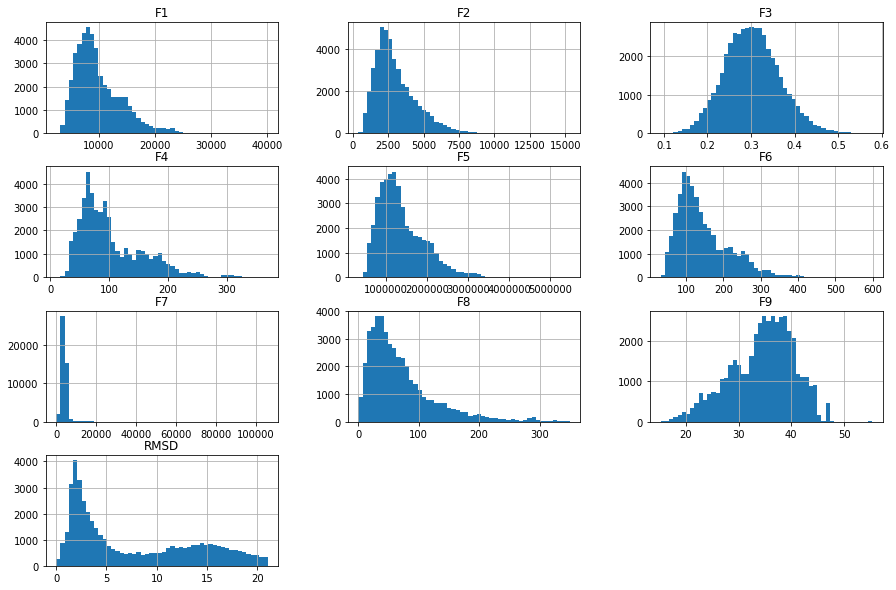

In [30]:
casp.hist(bins=50, figsize=(15,10));

Let us see if there is any missing data in the dataset

In [31]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [32]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

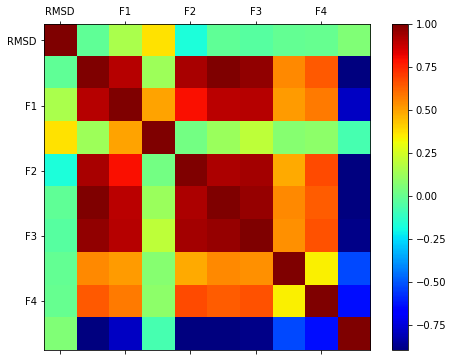

In [33]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

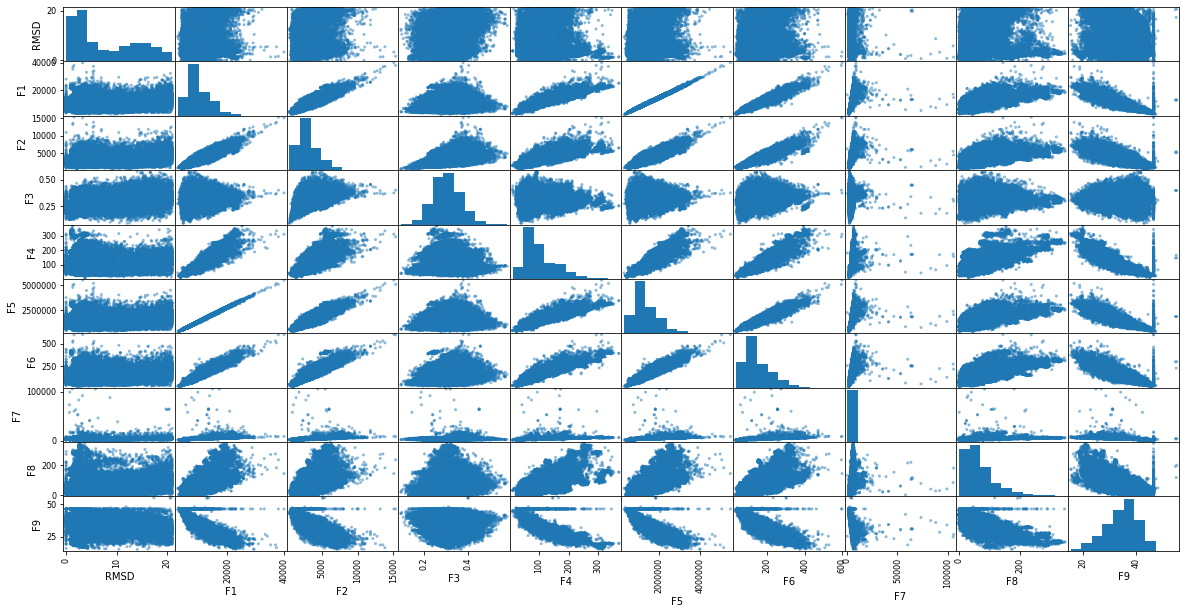

In [34]:
get_correlation(casp)

In [35]:
casp[casp['F7']<7500].corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.373967
F2      0.156547
F9      0.066031
F8     -0.001439
F5     -0.019722
F1     -0.020795
F7     -0.020812
F6     -0.042390
F4     -0.172639
Name: RMSD, dtype: float64

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

poly_features_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("minmax_scaler", MinMaxScaler())
])

X_train_scaled = poly_features_pipeline.fit_transform(X_train)

In [38]:
X_train_scaled.shape

(32011, 219)

In [39]:
print("Number of Features in the set " + str(X_train_scaled.shape[1]))

Number of Features in the set 219


We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [40]:
from sklearn.linear_model import LinearRegression
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Time taken 0.6923010349273682


In [41]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(10,6))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [42]:
X_test_scaled = poly_features_pipeline.fit_transform(X_test)

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  4.59728454182465 41.70974054504836


In [44]:
r2_model_score = r2_score(lin_reg.predict(X_test_scaled), y_test)

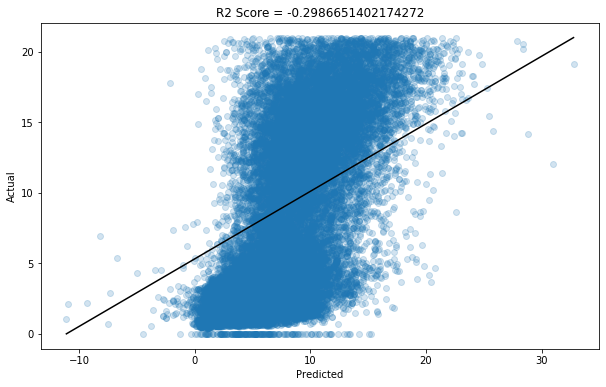

In [45]:
plot_results(X_train_scaled, y_train, lin_reg, "Without_PCA_Train")

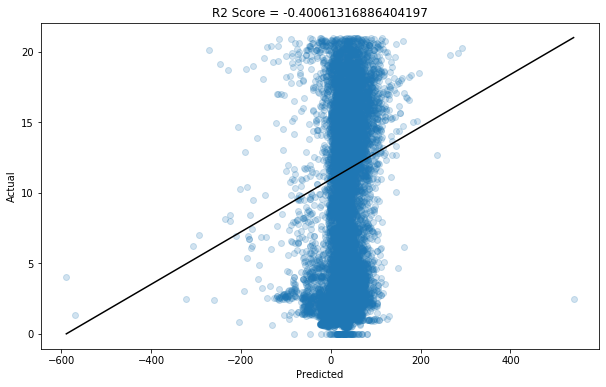

In [46]:
plot_results(X_test_scaled, y_test, lin_reg, "Without_PCA_Test")

# Use PCA and project the learning data onto a smaller space

In [47]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])

X_train_scaled = pca_pipeline.fit_transform(X_train)

In [48]:
pca_handle = pca_pipeline['pca']
pca_handle.explained_variance_ratio_.sum()

0.9909496582088837

In [49]:
X_train_scaled.shape

(32011, 10)

In [50]:
lin_reg_pca = LinearRegression()
start_time = time.time()
lin_reg_pca.fit(X_train_scaled, y_train)
print("time taken to fit = ", time.time()-start_time)

time taken to fit =  0.018338680267333984


In [51]:
rmse_X_scaled = np.sqrt(mean_squared_error(lin_reg_pca.predict(X_train_scaled),y_train))
print("RMSE is ",rmse_X_scaled)

RMSE is  5.253260176512374


In [52]:
X_test_scaled = pca_pipeline.transform(X_test)

In [53]:
rmse_test = np.sqrt(mean_squared_error(lin_reg_pca.predict(X_test_scaled),y_test))
print("RMSE on test set is ", rmse_test)

RMSE on test set is  5.284185473196075


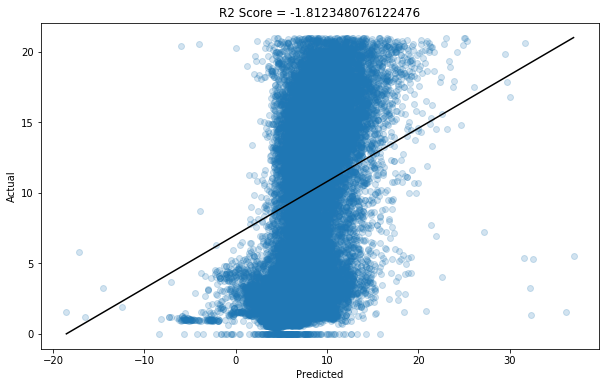

In [54]:
plot_results(X_train_scaled, y_train, lin_reg_pca, "With_PCA_Train")

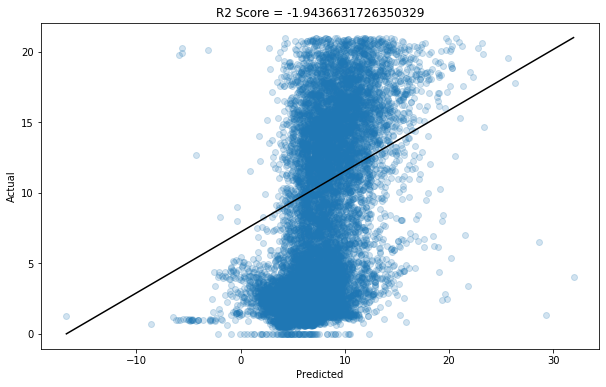

In [55]:
plot_results(X_test_scaled, y_test, lin_reg_pca, "With_PCA")

# Use Keras and fit a neural network to the data

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tensorflow import keras

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
])
casp_scaled = scaler_pipeline.fit_transform(casp)

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(casp_scaled[:,1:],casp_scaled[:,0], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=X_train[0,:].shape))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 6,101
Trainable params: 6,101
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.03))

In [60]:
history = model.fit(X_train, y_train, epochs=30, 
                   validation_data=(X_valid, y_valid))

Epoch 1/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0685 - val_loss: 0.0647
Epoch 2/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.0702
Epoch 3/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0607 - val_loss: 0.0605
Epoch 4/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0597 - val_loss: 0.0663
Epoch 5/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0590 - val_loss: 0.0616
Epoch 6/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0587
Epoch 7/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0584 - val_loss: 0.0582
Epoch 8/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0581 - val_loss: 0.0588
Epoch 9/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0578 - val_loss: 0.0579
Epoch 10/30
701/701 [==============================] - 1s 2ms/step - loss: 0.0577 - val_loss: 0.0581

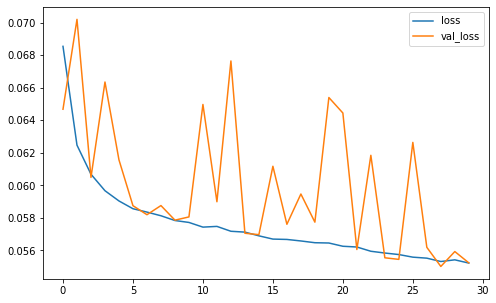

In [61]:
pd.DataFrame(history.history).plot(figsize=(8,5))

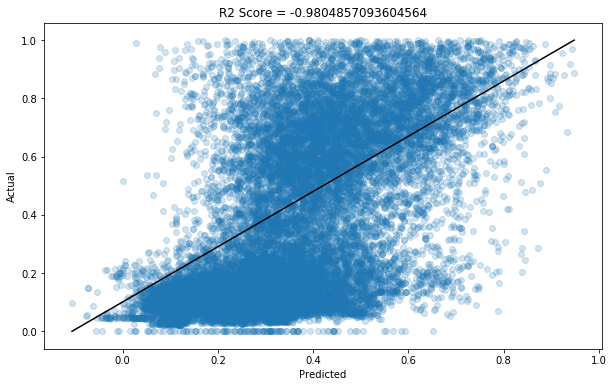

In [62]:
plot_results(X_train, y_train, model, "ANN")

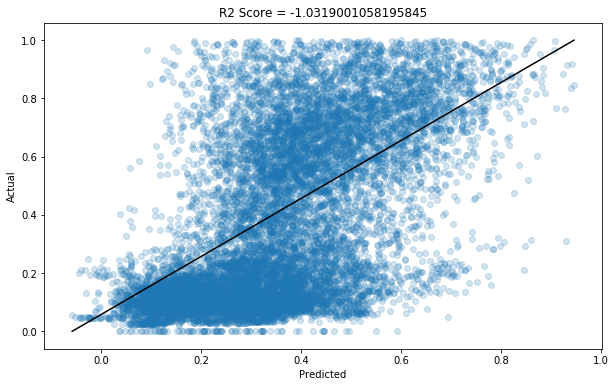

In [63]:
plot_results(X_test, y_test, model, "ANN_test")

# Transform the training data into lower dimensions using PCA

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])
casp_scaled = scaler_pipeline.fit_transform(casp)

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(casp_scaled[:,1:],casp_scaled[:,0], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

In [65]:
X_train.shape

(22407, 5)

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=X_train[0,:].shape))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.03))

In [69]:
history = model.fit(X_train, y_train, epochs=100, 
                   validation_data=(X_valid, y_valid))

Epoch 1/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0874 - val_loss: 0.0812
Epoch 2/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0721 - val_loss: 0.0674
Epoch 3/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0548
Epoch 4/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0502 - val_loss: 0.0495
Epoch 5/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0464 - val_loss: 0.0462
Epoch 6/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0447 - val_loss: 0.0446
Epoch 7/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0435 - val_loss: 0.0429
Epoch 8/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0426 - val_loss: 0.0451
Epoch 9/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0419 - val_loss: 0.0409
Epoch 10/100
701/701 [==============================] - 1s 2ms/step - loss: 0.0411 - val_lo

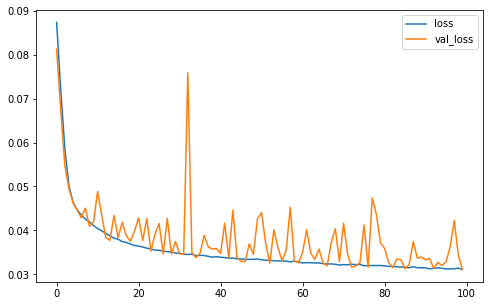

In [70]:
pd.DataFrame(history.history).plot(figsize=(8,5))

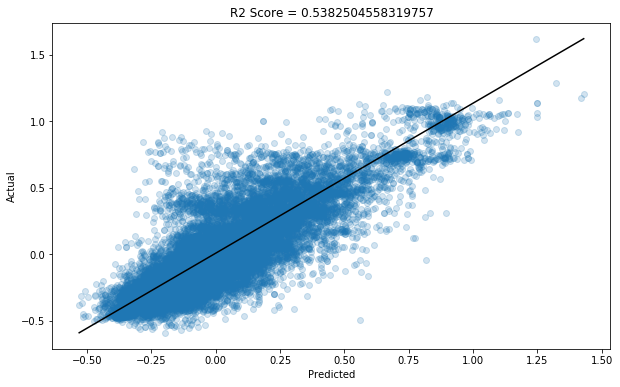

In [71]:
plot_results(X_train, y_train, model, "ANN")

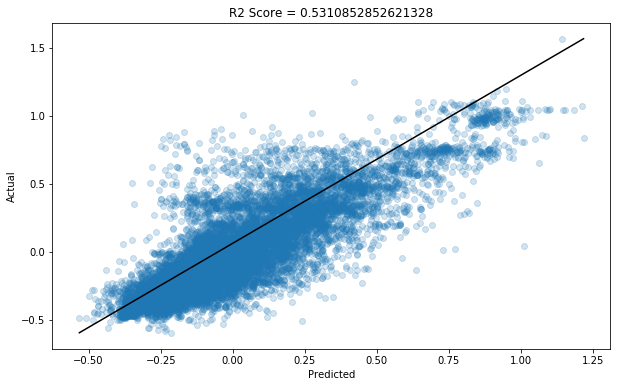

In [72]:
plot_results(X_test, y_test, model, "ANN_test")